In [24]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

In [ ]:
df1 = pd.read_csv('csv/gather1_fixed_core_vero.csv')
df2 = pd.read_csv('csv/gather2_fixed_core.csv')
df3 = pd.read_csv('csv/gather3_fixed_core.csv')

In [26]:
# Definizione della matrice delle latenze (questo è un esempio; dovrebbe essere definita con i valori reali)
LATENCY_CCX = 0.15e-6
LATENCY_CCD_DIFF_CCX = 0.31e-6
LATENCY_NUMA = 0.34e-6
LATENCY_SOCKET = 0.36e-6
LATENCY_DIFF_SOCKET = 0.65e-6
LATENCY_DIFF_NODE = 1.82e-6

# Costruzione della matrice delle latenze
MATRIX_TIMES = np.zeros((256, 256), dtype=np.float32)
for i in range(256):
    for j in range(256):
        if i == j:
            MATRIX_TIMES[i][j] = 0
        elif i // 4 == j // 4:
            MATRIX_TIMES[i][j] = LATENCY_CCX
        elif i // 16 == j // 16:
            MATRIX_TIMES[i][j] = LATENCY_CCD_DIFF_CCX
        elif i // 32 == j // 32:
            MATRIX_TIMES[i][j] = LATENCY_NUMA
        elif i // 64 == j // 64:
            MATRIX_TIMES[i][j] = LATENCY_SOCKET
        elif i // 128 == j // 128:
            MATRIX_TIMES[i][j] = LATENCY_DIFF_SOCKET
        else:
            MATRIX_TIMES[i][j] = LATENCY_DIFF_NODE

In [27]:
def basic_linear_gather_theoretical_model(matrix, num_cores, root=0, 
                                         overhead_fixed=0.0, 
                                         overhead_per_core=0.15, 
                                         unit='us'):
    """
    Calcola la latenza totale di un'operazione MPI_Gather lineare,
    considerando overhead fissi e per core.

    :param matrix: Matrice dei tempi di comunicazione (2D list o numpy array) in unità specificata
    :param num_cores: Numero totale di core utilizzati
    :param root: Rank del processo root (default=0)
    :param overhead_fixed: Overhead fisso per l'operazione di gather (in unità specificate)
    :param overhead_per_core: Overhead aggiuntivo per ciascun core (in unità specificate)
    :param unit: Unità di tempo dei dati della matrice ('s', 'ms', 'us')
    :return: Latenza totale del gather in microsecondi
    """
    # Definisci il fattore di conversione in microsecondi
    if unit == 's':
        factor = 1e6
    elif unit == 'ms':
        factor = 1e3
    elif unit == 'us':
        factor = 1.0
    else:
        raise ValueError("Unit must be 's', 'ms', or 'us'")

    # Estrai i tempi di invio dal root a tutti gli altri core
    send_times = [matrix[root][i] for i in range(num_cores) if i != root]
    
    # Debug: stampa i tempi di invio
    #print(f"Tempi di invio dal root (rank {root}): {send_times}")
    
    # Calcola il tempo massimo di invio
    if send_times:
        max_send_time = max(send_times)
        #print(f"Tempo massimo di invio: {max_send_time} {unit}")
    else:
        max_send_time = 0
        #print("Nessun invio necessario (numero di core = 1).")
    
    # Calcola l'overhead totale
    total_overhead = overhead_fixed + (overhead_per_core * num_cores)
    #print(f"Overhead totale: {total_overhead} {unit}")
    
    # Calcola la latenza totale come il tempo massimo di invio più l'overhead
    total_time = max_send_time + total_overhead
    
    # Converti in microsecondi
    total_latency = total_time * factor
    #print(f"Latenza totale del gather: {total_latency} µs")
    
    return total_latency

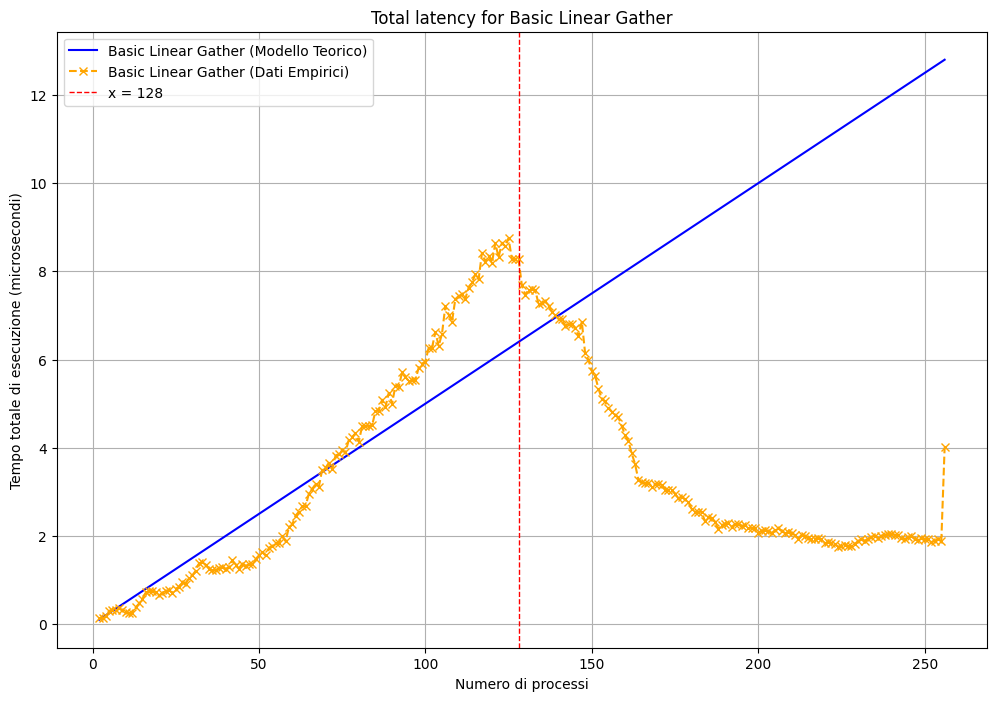

In [28]:
# Definizione della funzione per il modello basic linear gather
def basic_linear_nonblocking_with_overhead_corrected(matrix, num_cores, root=0, 
                                                     overhead_per_core=0.05):
    """
    Calcola la latenza totale del broadcast utilizzando invii non bloccanti,
    considerando un overhead che aumenta linearmente con il numero di core.

    :param matrix: Matrice dei tempi di comunicazione (2D list o numpy array) in unità specificata
    :param num_cores: Numero totale di core utilizzati
    :param root: Rank del processo root (default=0)
    :param overhead_per_core: Overhead aggiuntivo per ciascun core, in unità specificate
    :param unit: Unità di tempo dei dati della matrice ('s', 'ms', 'us')
    :return: Latenza totale del broadcast in microsecondi
    """


    # Estrai i tempi di invio dal root a tutti gli altri core
    send_times = [matrix[i][root] for i in range(num_cores) if i != root]
    
    # Debug: stampa i tempi di invio
    #print(f"Tempi di invio dal root (rank {root}): {send_times}")
    
    # Calcola il tempo massimo di invio
    if send_times:
        max_time = max(send_times)
        #print(f"Tempo massimo di invio: {max_time} {unit}")
    else:
        max_time = 0
        #print("Nessun invio necessario (numero di core = 1).")
    
    # Calcola l'overhead totale basato sul numero di core
    total_overhead = overhead_per_core * num_cores
    #print(f"Overhead totale: {total_overhead} {unit}")
    
    # Calcola la latenza totale come il tempo massimo di invio più l'overhead
    total_time = max_time + total_overhead
    
    # Converti in microsecondi
    total_latency = total_time
    #print(f"Latenza totale del broadcast: {total_latency} µs")
    
    return total_latency

# Eseguire il calcolo per un range di processi da 2 a 256
max_processes = 256
root = 0  # Assumiamo che il root sia il processo 0
theoretical_times = [basic_linear_nonblocking_with_overhead_corrected(MATRIX_TIMES, n, root) for n in range(2, max_processes + 1)]

# Plottare l'andamento del modello teorico all'aumentare del numero di processi
plt.figure(figsize=(12, 8))
plt.plot(range(2, max_processes + 1), theoretical_times, label='Basic Linear Gather (Modello Teorico)', color='blue')
plt.plot(df1['Processes'], df1['Latency'], label='Basic Linear Gather (Dati Empirici)', color='orange', marker='x', linestyle='--')
plt.axvline(x=128, color='red', linestyle='--', linewidth=1, label='x = 128')
plt.xlabel('Numero di processi')
plt.ylabel('Tempo totale di esecuzione (microsecondi)')
plt.title('Total latency for Basic Linear Gather')
plt.legend()
plt.grid(True)
plt.show()

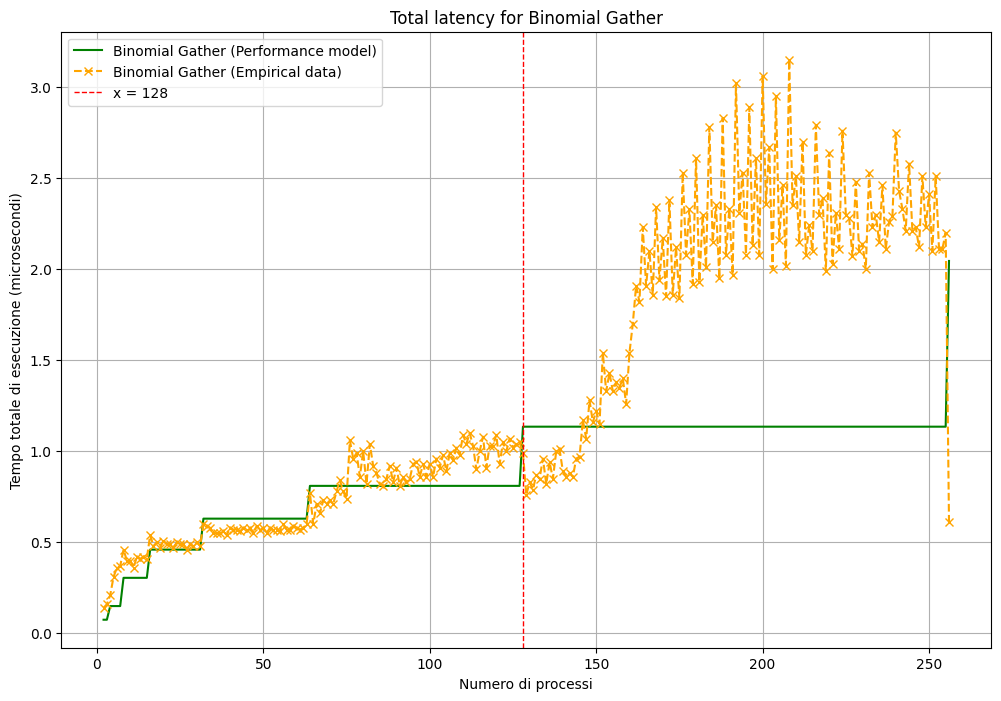

In [29]:
def binomial_gather_model(matrix_times, num_processes, root=0):
    """
    Calcola il tempo totale di esecuzione per l'algoritmo binomial gather
    utilizzando i tempi diretti della matrice delle latenze.

    :param matrix_times: matrice delle latenze tra processi (inclusa la latenza per 4 byte)
    :param num_processes: numero di processi da includere nel gather
    :param root: processo root (default: 0)
    :return: tempo totale di esecuzione teorico in microsecondi
    """
    total_time = 0
    levels = int(math.log2(num_processes))  # Numero di livelli nell'albero binomiale

    # Calcola il tempo massimo di latenza per ciascun livello dell'albero
    for level in range(levels):
        # La distanza tra i nodi che comunicano in questo livello è 2^level
        step = 2 ** level
        max_latency = 0
        for i in range(0, num_processes, 2 * step):
            if i + step < num_processes:
                # Calcola la latenza tra il processo i e i + step (genitore e figlio in questo livello)
                latency = matrix_times[i + step][i] if i != root else matrix_times[i][i + step]
                max_latency = max(max_latency, latency)
        total_time += max_latency

    return total_time*1e6   # Converti il risultato in microsecondi

# Eseguire il calcolo per un range di processi da 2 a 256
max_processes = 256
root = 0  # Assumiamo che il root sia il processo 0
theoretical_times_binomial = [binomial_gather_model(MATRIX_TIMES/2, n, root) for n in range(2, max_processes + 1)]


plt.figure(figsize=(12, 8))
plt.plot(range(2, max_processes + 1), theoretical_times_binomial, label='Binomial Gather (Performance model)', color='green')
plt.plot(df2['Processes'], df2['Latency'], label='Binomial Gather (Empirical data)', color='orange', marker='x', linestyle='--')
plt.axvline(x=128, color='red', linestyle='--', linewidth=1, label='x = 128')

plt.xlabel('Numero di processi')
plt.ylabel('Tempo totale di esecuzione (microsecondi)')
plt.title('Total latency for Binomial Gather')
plt.legend()
plt.grid(True)
plt.show()

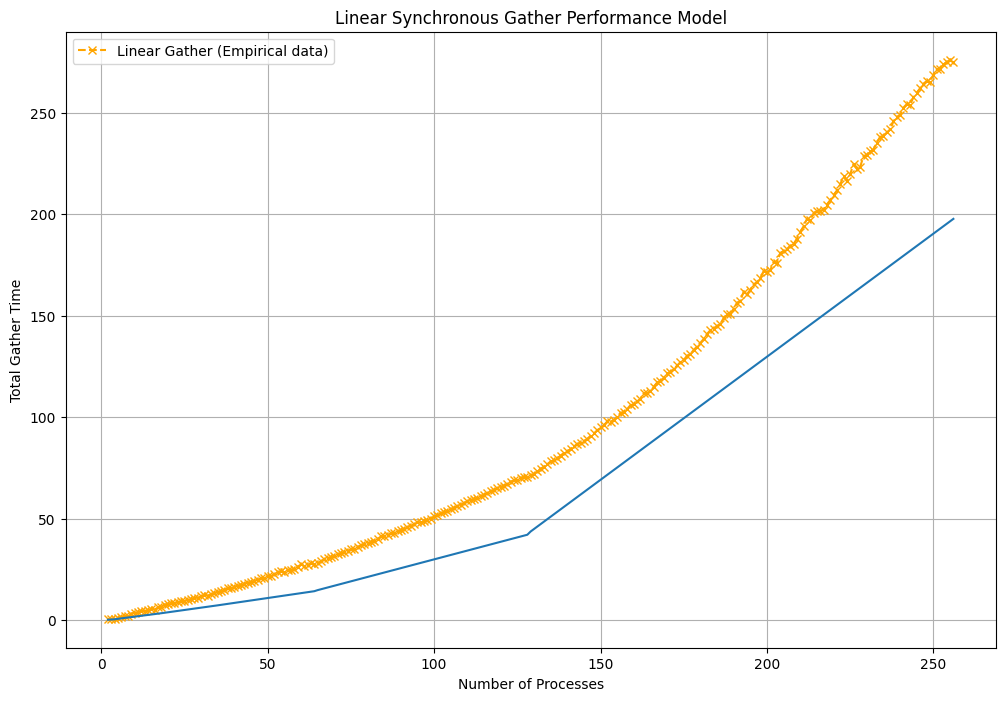

In [33]:
def gather_linear_sync(matrix, num_cores, root=0):

    first_time = [(matrix[i][root])*(2/3) for i in range(num_cores) if i != root]
    first_time = sum(first_time)
    # Estrai i tempi di invio dal root a tutti gli altri core
    second_chunk_times = [(matrix[root][i])/3 for i in range(num_cores) if i != root]
    
    # Debug: stampa i tempi di invio
    #print(f"Tempi di invio dal root (rank {root}): {send_times}")
    
    # Calcola il tempo massimo di invio
    if second_chunk_times:
        max_second_time = max(second_chunk_times)
        #print(f"Tempo massimo di invio: {max_time} {unit}")
    else:
        max_second_time = 0
        #print("Nessun invio necessario (numero di core = 1).")
    
    total_time = max_second_time + first_time
    
    
    return total_time*1e6

N = 256
latency_results = {}
for num_cores in range(2, 257):  # from 2 up to 256 cores
    latency_results[num_cores] = gather_linear_sync(MATRIX_TIMES, num_cores)

# plot comparison 
plt.figure(figsize=(12, 8))
plt.plot(df3['Processes'], df3['Latency'], label='Linear Gather (Empirical data)', color='orange', marker='x', linestyle='--')
plt.plot(latency_results.keys(), latency_results.values())
plt.xlabel('Number of Processes')
plt.ylabel('Total Gather Time')
plt.title('Linear Synchronous Gather Performance Model')
plt.legend()
plt.grid(True)
plt.show()